# Imports

In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import math
import numpy as np
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import svm

# Generic Functions

In [2]:
def getStockHistory(stockTicker, sourceSite, startDate, endDate):
    df = web.DataReader(stockTicker, sourceSite, startDate, endDate)
    return df

def computeMovingAverage(close_px, window):
    mavg = close_px.rolling(window=window).mean()
    return mavg

def stocksRRR(retscomp):
    plt.scatter(retscomp.mean(), retscomp.std())
    plt.xlabel('Expected returns')
    plt.ylabel('Risk')
    for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
        plt.annotate(
            label, 
            xy = (x, y), xytext = (20, -20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.show()

In [47]:
def predictAndPlot(clf, X_lately, dfreg, confidence, forecast_out):
    forecast_set = clf.predict(X_lately)
    dfreg['Forecast'] = np.nan
    print(forecast_set, confidence, forecast_out)

    # Plot
    dfreg['Forecast'] = np.nan
    last_date = dfreg.iloc[-1].name
    last_unix = last_date
    next_unix = last_unix + datetime.timedelta(days=1)

    for i in forecast_set:
        next_date = next_unix
        next_unix += datetime.timedelta(days=1)
        dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(type(clf).__name__)
    plt.show()

# Stock Forecasting

In [4]:
# reading stock from yahoo finance
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)
df = getStockHistory('AAPL', 'yahoo', start, end)

In [5]:
print(df.tail())

                  High         Low        Open       Close      Volume  \
Date                                                                     
2017-01-05  116.860001  115.809998  115.919998  116.610001  22193600.0   
2017-01-06  118.160004  116.470001  116.779999  117.910004  31751900.0   
2017-01-09  119.430000  117.940002  117.949997  118.989998  33561900.0   
2017-01-10  119.379997  118.300003  118.769997  119.110001  24462100.0   
2017-01-11  119.930000  118.599998  118.739998  119.750000  27588600.0   

             Adj Close  
Date                    
2017-01-05  111.727715  
2017-01-06  112.973305  
2017-01-09  114.008080  
2017-01-10  114.123047  
2017-01-11  114.736275  


In [7]:
#compute rolling mean and rate of return
close_px = df['Adj Close']

In [8]:
print(close_px.tail())

Date
2017-01-05    111.727715
2017-01-06    112.973305
2017-01-09    114.008080
2017-01-10    114.123047
2017-01-11    114.736275
Name: Adj Close, dtype: float64


In [9]:
mavg = computeMovingAverage(close_px, 100)

In [10]:
# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(8, 7))

In [11]:
print("mpl version = ", mpl.__version__)

mpl version =  3.1.1


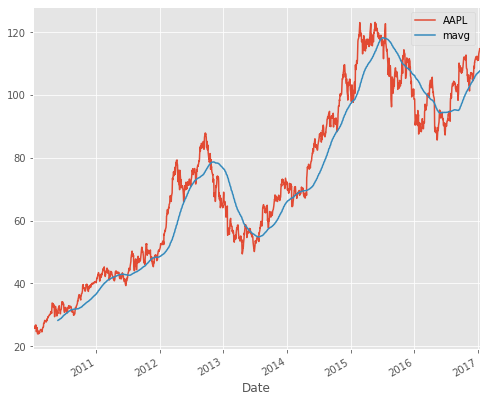

In [12]:
# Adjusting the style of matplotlib
style.use('ggplot')
close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()
plt.show()

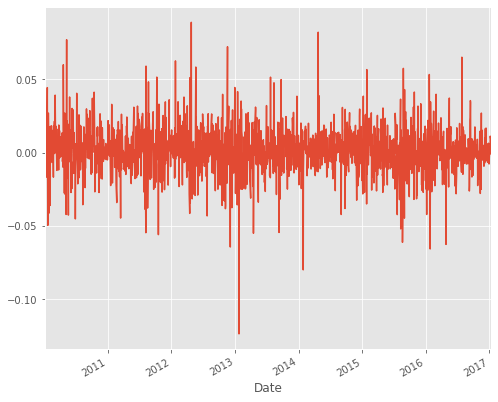

In [14]:
# compute returns
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')
plt.show()

# Analyze competitor stocks

In [16]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [17]:
print(dfcomp.tail())

Symbols           AAPL         GE        GOOG         IBM       MSFT
Date                                                                
2017-01-05  111.727715  27.941267  794.020020  150.013260  59.230362
2017-01-06  112.973305  28.021051  806.150024  150.751312  59.743763
2017-01-09  114.008080  27.888081  806.650024  149.079559  59.553616
2017-01-10  114.123047  27.808300  804.789978  147.185501  59.534603
2017-01-11  114.736275  27.896944  807.909973  149.168472  60.076519


In [18]:
# correlation analysis
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

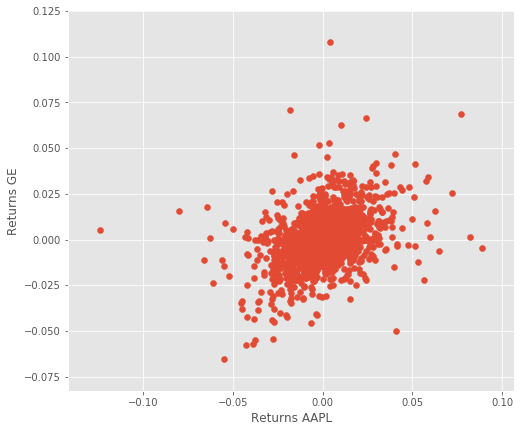

In [19]:
# scatter plot the result
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')
plt.show()

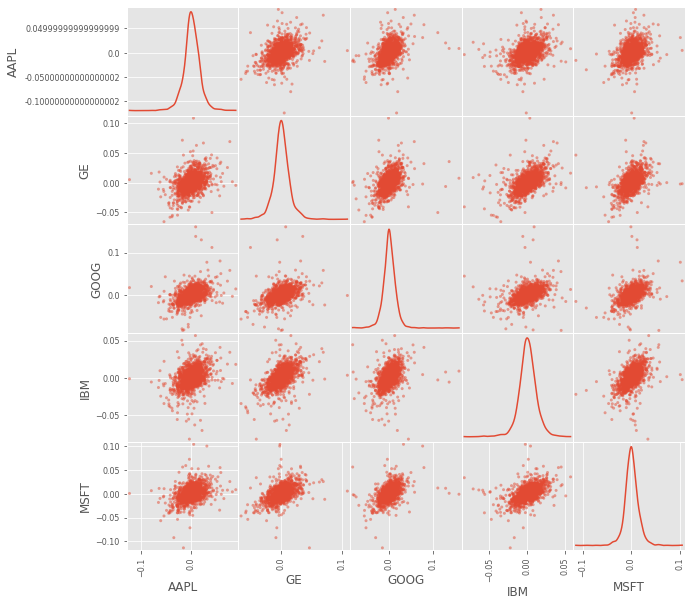

In [20]:
# Kernet Density Estimate (KDE)
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10))
plt.show()

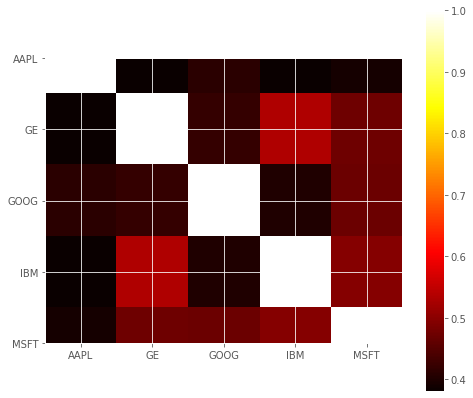

In [21]:
# heat map corrolation
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)
plt.show()

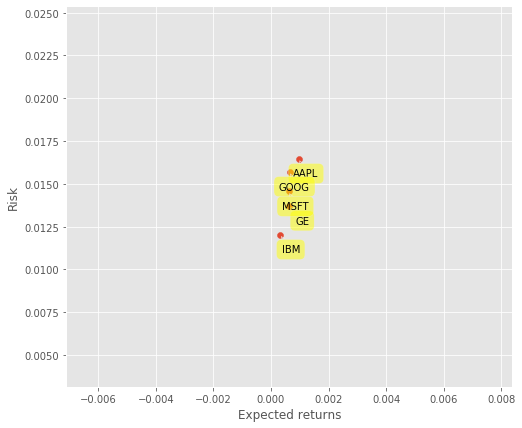

In [22]:
stocksRRR(retscomp)

# Predict Stock Prices (Regression and KNN)

In [23]:
# Load the data
dfreg = df.loc[:,['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [24]:
print(dfreg.tail())

             Adj Close      Volume    HL_PCT  PCT_change
Date                                                    
2017-01-05  111.727715  22193600.0  0.900440    0.595240
2017-01-06  112.973305  31751900.0  1.433299    0.967636
2017-01-09  114.008080  33561900.0  1.252204    0.881730
2017-01-10  114.123047  24462100.0  0.906720    0.286271
2017-01-11  114.736275  27588600.0  1.110649    0.850600


In [25]:
# cleanup process
# --------------------------------------------------------------------

# drop missing values
dfreg.fillna(value=-99999, inplace=True)

# we want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'],1))

# scale the X so that everyone can have the same distribution for linear regression
X = sk.preprocessing.scale(X)

# find data series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [27]:
print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

Dimension of X (1751, 4)
Dimension of y (1751,)


In [28]:
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2)

In [29]:
# Linear Regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [30]:
# Lasso Regression
clflasso = Lasso(selection='random')
clflasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='random', tol=0.0001, warm_start=False)

In [31]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [32]:
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [33]:
# KNN
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [34]:
# Test the models
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
confidencelasso = clflasso.score(X_test, y_test)

In [35]:
print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The quadratic regression 3 confidence is ",confidencepoly3)
print("The knn regression confidence is ",confidenceknn)
print("The knn lasso confidence is ",confidencelasso)

The linear regression confidence is  0.9656539508231162
The quadratic regression 2 confidence is  0.9546413801639551
The quadratic regression 3 confidence is  0.9281828039118936
The knn regression confidence is  0.9369935878640699
The knn lasso confidence is  0.9640042181345472


[110.83409824 110.74886442 112.02503905 112.07952703 112.02602825
 111.41898403 111.85351489 112.64058947 112.4760169  111.95820985
 111.39356717 111.55890006 111.21126095 111.83831291 113.1038596
 113.95287616 114.10110286 114.69702959] 0.9656539508231162 18


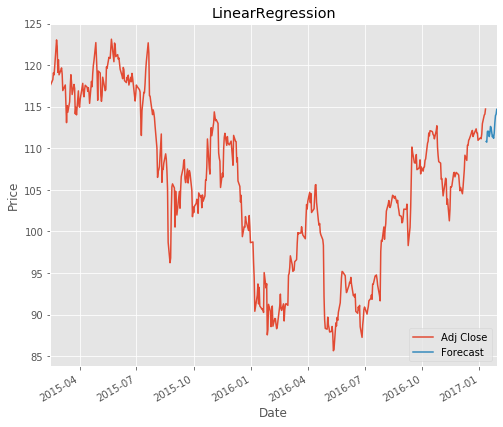

In [52]:
predictAndPlot(clfreg, X_lately, dfreg.copy(), confidencereg, forecast_out)

[109.89346392 109.86610467 111.55458814 111.81374226 111.68855612
 111.05874121 111.89052661 112.43462007 112.32424169 111.94195705
 111.00134935 111.1290073  111.05551992 111.57925251 112.34340297
 113.02485021 113.49083034 113.88460258] 0.9546413801639551 18


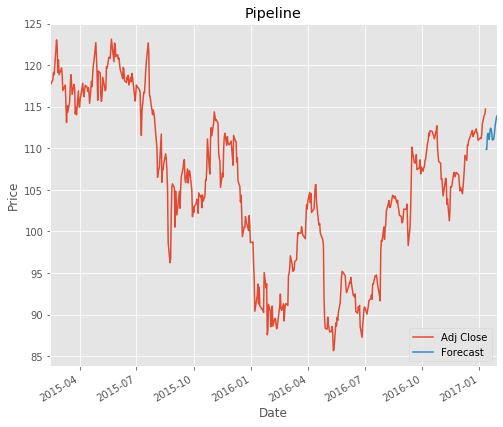

In [51]:
predictAndPlot(clfpoly2, X_lately, dfreg.copy(), confidencepoly2, forecast_out)

[109.77034822 108.45898669 111.14472762 110.81107842 110.48569142
 110.01263833 111.41187198 111.82284758 111.62374663 110.99902367
 110.48332352 110.71989904 110.12901991 110.99546037 111.87668325
 112.45468492 112.41223019 113.06638814] 0.9281828039118936 18


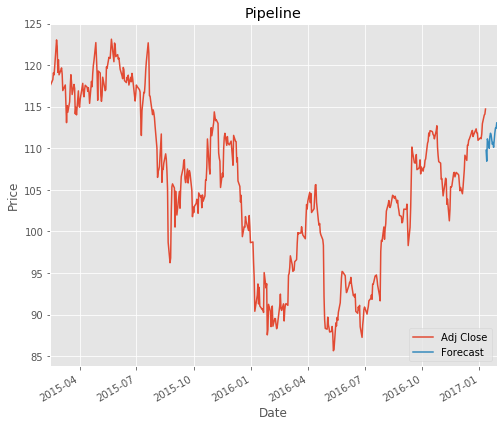

In [50]:
predictAndPlot(clfpoly3, X_lately, dfreg.copy(), confidencepoly3, forecast_out)

[110.34494019 112.58226395 103.22626877 107.21224976 108.24702454
 103.98313904 108.75272369 112.76696777 102.93068314 108.24702454
 102.93068314 108.41541672 107.21224976 108.75272369 116.62772369
 114.43230438 110.31904984 112.71194077] 0.9369935878640699 18


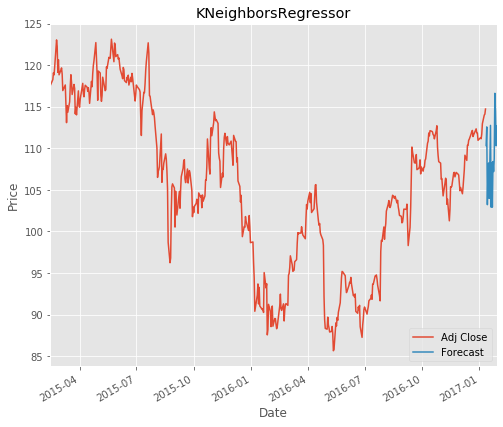

In [49]:
predictAndPlot(clfknn, X_lately, dfreg.copy(), confidenceknn, forecast_out)

[109.65488872 109.79859856 110.46977157 110.77471468 110.86324025
 110.16333338 110.41995708 111.06589694 110.606656   110.60480055
 109.72290376 110.02634953 109.9425529  110.46671154 111.591021
 112.55120344 112.69757416 113.25783244] 0.9640042181345472 18


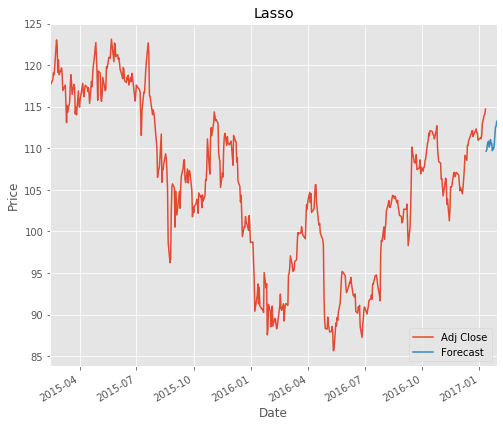

In [48]:
predictAndPlot(clflasso, X_lately, dfreg.copy(), confidencelasso, forecast_out)